In [161]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import keras.backend as K
import random

from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import classification_report, confusion_matrix

tfk = tf.keras
tfkl = tfk.layers
seed = 100
plt.style.use('ggplot')

UNROLL_WINDOW = True            # <---------- set this True if you want to recompute the dataset with a new stride, otherwise pre load it.

In [162]:
DATA_DIR = '/kaggle/input/timeseries-challenge'
X = np.load(f'{DATA_DIR}/x_train.npy')
y = np.load(f'{DATA_DIR}/y_train.npy')

X.shape

(2429, 36, 6)

## Exploratory analysis

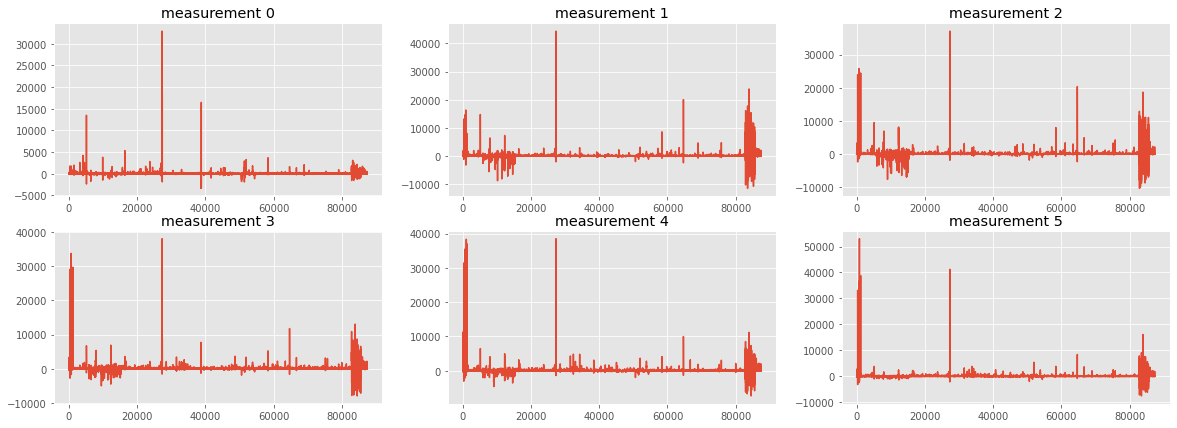

In [163]:
df = {}
for m in range(X.shape[2]):
    x = np.reshape(X[:, :, m], (X.shape[0] * X.shape[1]))
    df[f'measurement {m}'] = x

df = pd.DataFrame(df)

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 7))


for c, a in zip(df.columns[0: 3], axs[0]):
    a.set_title(c)
    a.plot([i for i in range(df.shape[0])], df[c])
    
for c, a in zip(df.columns[3: ], axs[1]):
    a.set_title(c)
    a.plot([i for i in range(df.shape[0])], df[c])

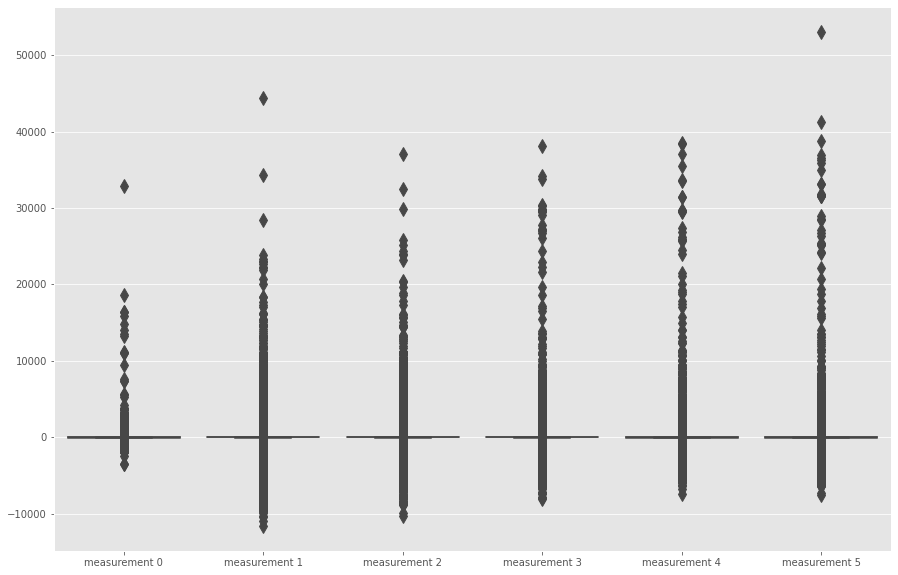

In [164]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df[df.columns], fliersize=10)
plt.show()

# Robust scaling
Since there are a lot of outliers with high values, use robust scaler, so that the normalization is not influenced by the outliers.

In [165]:
median_s = []
percentile_25_s = []
percentile_75_s = []
interquantile_s = []
x_s = []
X_scaled = X.copy()

for m in range(X.shape[2]):
    x = np.reshape(X[:, :, m], (X.shape[0] * X.shape[1]))
    
    median = np.median(x)
    median_s.append(median)
    
    percentile_75 = np.percentile(x, 75)
    percentile_25 = np.percentile(x, 25)
    percentile_75_s.append(percentile_75)
    percentile_25_s.append(percentile_25)
    
    interquantile_range = percentile_75 - percentile_25
    interquantile_s.append(interquantile_range)
    
    x_s.append((x - median) / interquantile_range)
    X_scaled[:, :, m] = (X[:, :, m] - median) / interquantile_range

median_s

[0.27551499999999995,
 0.41078,
 0.65208,
 0.9440949999999999,
 1.28675,
 2.1140499999999998]

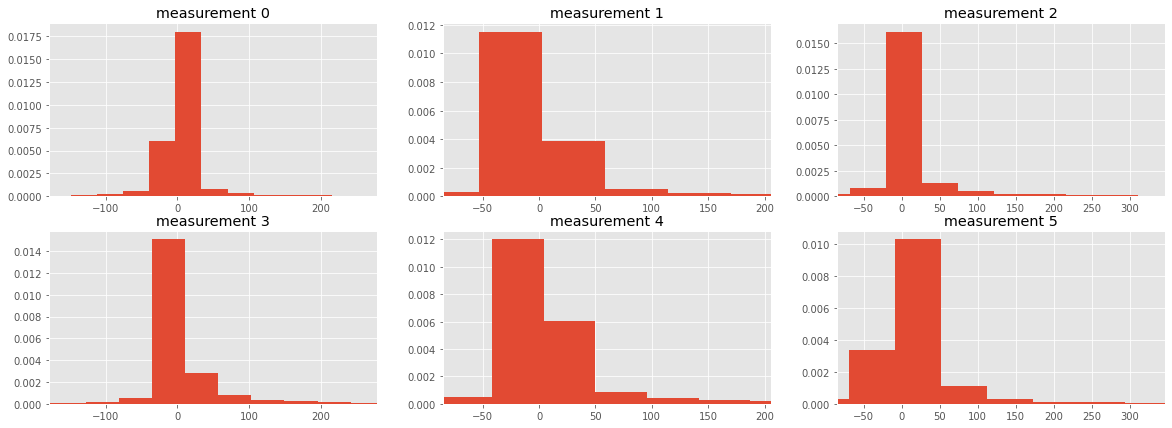

In [166]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 7))

lambda_c = 50
n_bins = 1000

for c, a, p75, p25 in zip(df.columns[0: 3], axs[0], percentile_75_s, percentile_25_s):
    a.set_title(c)
    a.hist(df[c], bins=n_bins, density=True)
    a.set_xlim([p25 * lambda_c, p75 * lambda_c])
    
for c, a, p75, p25 in zip(df.columns[3: ], axs[1], percentile_75_s, percentile_25_s):
    a.set_title(c)
    a.hist(df[c], bins=n_bins, density=True)
    a.set_xlim([p25 * lambda_c, p75 * lambda_c])

Measurements seem to present a Gaussian distribution. Using a robust scaling makes sense.

## saving training data info for later test preprocessing

In [167]:
np.save('median', median_s)
np.save('interquantile', interquantile_s)

In [168]:
df = {}
for m, x in zip(range(X.shape[2]), x_s):
    df[f'measurement {m}'] = x
    print(f'measurement {m} | median: {np.mean(x): 0.1}, \t interquantile range: {np.percentile(x, 75) - np.percentile(x, 25)}')

df = pd.DataFrame(df)

measurement 0 | median:  1e+00, 	 interquantile range: 1.0000000000000002
measurement 1 | median:  3e+00, 	 interquantile range: 1.0000000000000002
measurement 2 | median:  3e+00, 	 interquantile range: 1.0
measurement 3 | median:  3e+00, 	 interquantile range: 1.0
measurement 4 | median:  2e+00, 	 interquantile range: 1.0
measurement 5 | median:  1e+00, 	 interquantile range: 1.0


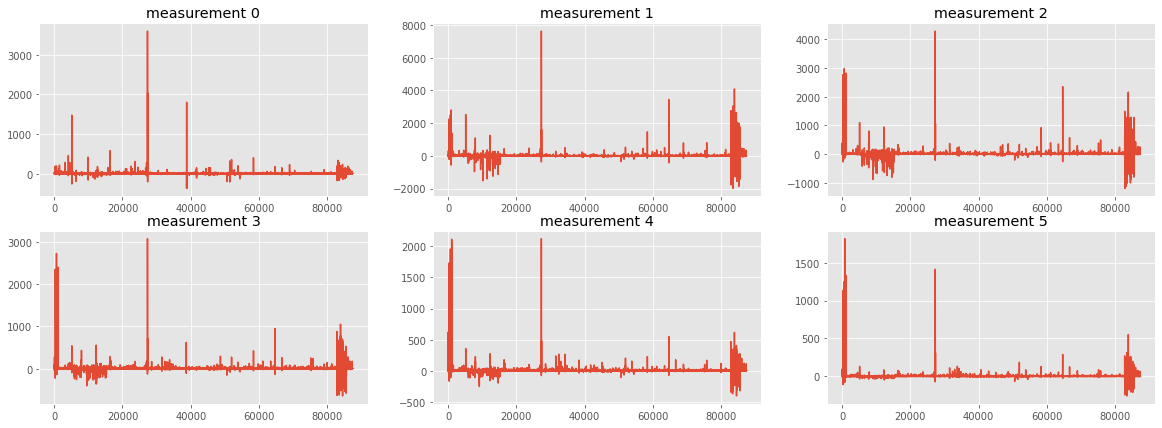

In [169]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 7))


for c, a in zip(df.columns[0: 3], axs[0]):
    a.set_title(c)
    a.plot([i for i in range(df.shape[0])], df[c])
    
for c, a in zip(df.columns[3: ], axs[1]):
    a.set_title(c)
    a.plot([i for i in range(df.shape[0])], df[c])

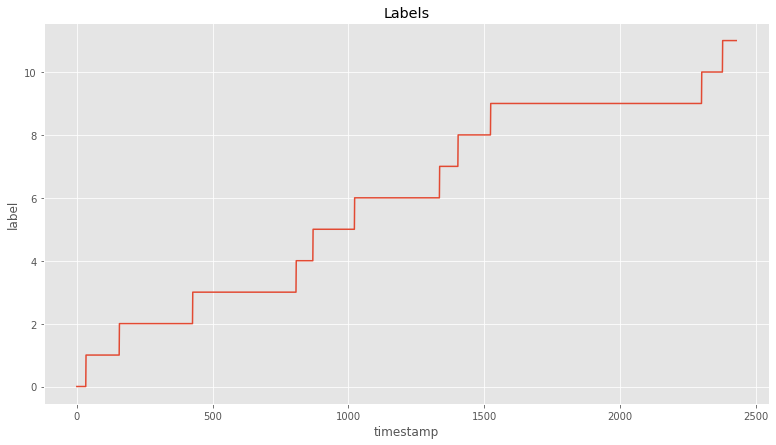

In [170]:
plt.figure(figsize=(13, 7))
plt.title('Labels')
plt.plot([i for i in range(y.shape[0])], y)
plt.xlabel('timestamp')
plt.ylabel('label')
plt.show()

Each sample is indipendent to each other sample, so we can shuffle them, (I GUESS)

### Plot distribution of the labels

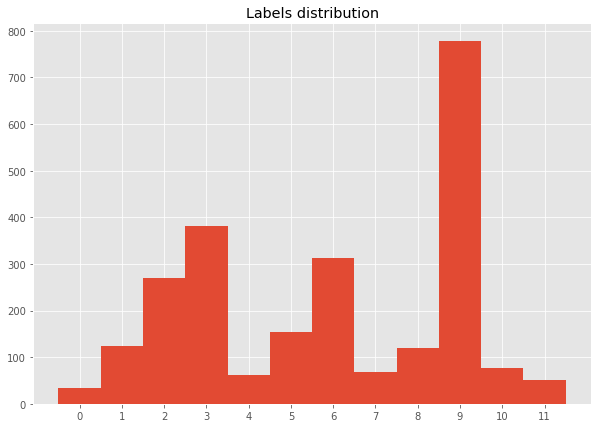

In [171]:
plt.figure(figsize=(10, 7))
plt.title('Labels distribution')
plt.hist(y, bins=range(13))
plt.xticks(ticks=np.arange(0.5, 12.5, 1), labels=np.arange(0, 12, 1))
plt.show()

## Compute weights for classes

In [172]:
counter = np.bincount(y)
frequencies = 1 / counter
weights = frequencies * (y.shape[0] / frequencies.shape[0])

w_s = {}
for i, w in enumerate(weights):
    w_s[i] = w
w_s

{0: 5.953431372549019,
 1: 1.6456639566395665,
 2: 0.7496913580246913,
 3: 0.5312773403324584,
 4: 3.264784946236559,
 5: 1.3229847494553377,
 6: 0.6466986155484558,
 7: 2.9767156862745097,
 8: 1.6868055555555554,
 9: 0.2605105105105105,
 10: 2.628787878787879,
 11: 3.9689542483660127}

In [173]:
1 / frequencies

array([ 34., 123., 270., 381.,  62., 153., 313.,  68., 120., 777.,  77.,
        51.])

# Utility functions for data preprocessing pipeline

In [180]:
def change_windows(x, y, step_size=1):
    
    x = x.copy()
    y = y.copy()
    
    # concatenate time series
    x = np.reshape(x, (x.shape[0] * x.shape[1], x.shape[2]))
    y = np.repeat(y, 36)
    
    # find starting indexes for each label.
    df = pd.DataFrame({'y': y})
    last_index = df.index[-1] + 1
    starting_indexes = list(df.drop_duplicates(keep='first').index.values)
    ending_indexes = starting_indexes[1:]
    ending_indexes = ending_indexes + [last_index]
    
    x_augmented = None
    y_augmented = []
    
    starting_index = 0
    expected_samples = 0
    for label, end_label_index in enumerate(ending_indexes):
        print(f"augmenting {label}, start at: {starting_index}; end at: {end_label_index}")
        
        assert starting_index < end_label_index - 36 + 1
        for i in range(starting_index, end_label_index - 36 + 1, step_size):
            if x_augmented is None:
                x_augmented = np.expand_dims(x[i: i + 36, :], axis=0)
            else:
                x_augmented = np.append(x_augmented, np.expand_dims(x[i: i + 36, :], axis=0), axis=0)
            y_augmented.append(label)
        
        starting_index = end_label_index
    
    y_augmented = np.array(y_augmented)
    
    assert x_augmented.shape[1] == 36
    assert x_augmented.shape[2] == 6
    
    return x_augmented, y_augmented 

if UNROLL_WINDOW:
    X = robust_scaling(X)
    X, y = change_windows(X, y)
    np.save('X_stride1', X)
    np.save('y_stride1', y)
else:
    X = np.load('/augmented/X_stride1.npy')
    y = np.load('/augmented/y_stride1.npy')

augmenting 0, start at: 0; end at: 1224
augmenting 1, start at: 1224; end at: 5652
augmenting 2, start at: 5652; end at: 15372
augmenting 3, start at: 15372; end at: 29088
augmenting 4, start at: 29088; end at: 31320
augmenting 5, start at: 31320; end at: 36828
augmenting 6, start at: 36828; end at: 48096
augmenting 7, start at: 48096; end at: 50544
augmenting 8, start at: 50544; end at: 54864
augmenting 9, start at: 54864; end at: 82836
augmenting 10, start at: 82836; end at: 85608
augmenting 11, start at: 85608; end at: 87444


In [181]:
X.shape

(87024, 36, 6)